In [15]:
import time, sys, joblib

import pandas as pd

sys.path.append('/home/yilingh/SI-Interaction')
from selectinf.Simulation.plotting_helpers import *
from selectinf.Simulation.H1.nonlinear_H1_helpers import *

In [16]:
from operator import le, ge
def filter_pval_dict_new(target_dict, threshold=0.05, operator=le, p_flag="pivot"):
    grouped_targets = pd.DataFrame(target_dict).groupby(['parameter', 'method'])
    filtered_dict = {}
    # Filter by 
    for name, group in grouped_targets:
        # Subset the selected targets
        selected_targets_id = operator(np.abs(group['target']), threshold)
        selected_targets = group[p_flag][selected_targets_id]
        # Then filtered_dict.keys must be a dictionary
        if name[0] in filtered_dict.keys():
            filtered_dict[name[0]][name[1]] = selected_targets.tolist()
        else:
            filtered_dict[name[0]] = {}
            filtered_dict[name[0]][name[1]] = selected_targets.tolist()
        
    return filtered_dict
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_MSE(oper_char):
    specific_method = "MLE"  # Replace with the name of your method
    
    # Create a modified DataFrame
    df_modified = oper_char.copy()
    
    # For the specific method, keep "tau" values separate
    # For other methods, set "tau" to a single category, e.g., "All"
    df_modified['prop'] = df_modified.apply(
        lambda row: row['prop'] if row['method'] == specific_method else 'Naive/DS', axis=1
    )
    
    # Plotting
    sns.boxplot(x='method', y='MSE', hue='prop', data=df_modified, showmeans=True)
    plt.xlabel("Method")
    plt.ylabel("MSE")
    plt.title("Boxplot of MSE by Method and prop")
    plt.show()


In [17]:
def combine_dicts(dict, new_dict):
    for key in dict.keys():
        dict[key] = dict[key] + new_dict[key]
        
    return dict

In [18]:
def combine_nested_dicts(dict, new_dict):
    combined_dict = {}
    for key in dict.keys():
        combined_dict[key] = combine_dicts(dict[key], new_dict[key])
    
    return combined_dict

# Vary interaction signal with weak Hierarchy

In [19]:
n_task_per_file = 50
n_files = 10
base_dir = "vary_interaction_"
files_list = []
for i in range(n_files):
    dir = base_dir + str(i*n_task_per_file) + "_"  + str((i+1)*n_task_per_file) + ".pkl"
    files_list.append(dir)

In [20]:
oper_char_full = None
ds_rank_def_count_full = None
target_dict_full = None
pval_dict_full = None
MSE_dict_full = None

for path in files_list:
    ds_rank_def_count, target_dict, pval_dict, MSE_dict, oper_char = joblib.load(path)
    # Combine ds_rank_def_count
    if not ds_rank_def_count_full:
        ds_rank_def_count_full = ds_rank_def_count
    else:
        ds_rank_def_count_full = combine_dicts(ds_rank_def_count_full, ds_rank_def_count)
    # Combine target_dict
    if not target_dict_full:
        target_dict_full = target_dict
    else:
        target_dict_full = combine_dicts(target_dict_full, target_dict)
    if not pval_dict_full:
        pval_dict_full = pval_dict
    else:
        pval_dict_full = combine_nested_dicts(pval_dict_full, pval_dict)
    # Combine MSE_dict
    if not MSE_dict_full:
        MSE_dict_full = MSE_dict
    else:
        MSE_dict_full = combine_dicts(MSE_dict_full, MSE_dict)
    # Combine oper_char
    if not oper_char_full:
        oper_char_full = oper_char
    else:
        oper_char_full = combine_dicts(oper_char_full, oper_char)

In [21]:
ds_rank_def_count_full

{0.5: 0, 1.0: 0, 2.0: 161, 5.0: 0}

In [29]:
## Plotting dict: SNR - Method - List of pvals
filtered_dict = filter_pval_dict_new(target_dict, threshold = 0,
                                     operator=ge)

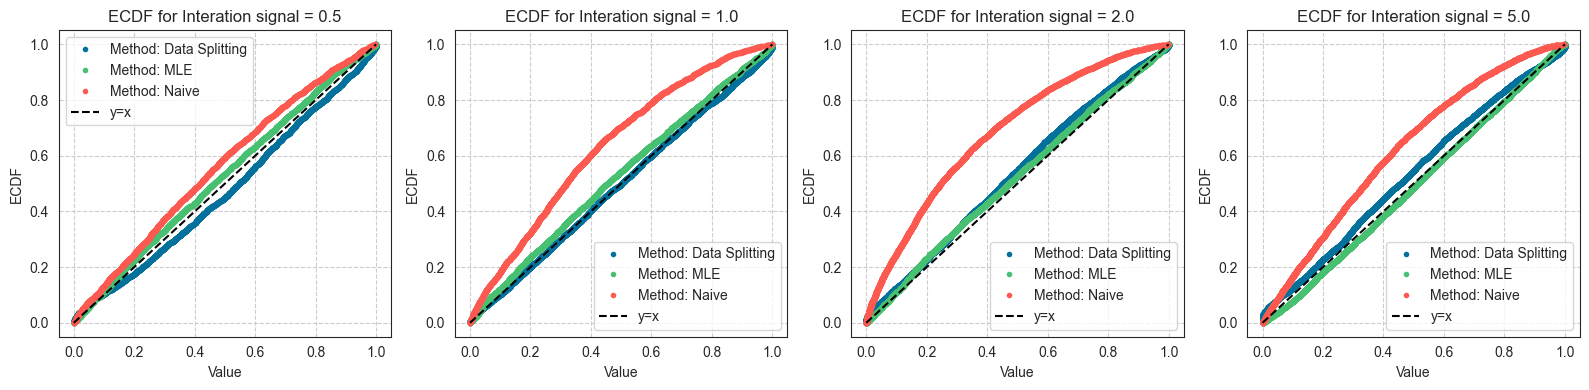

In [30]:
plot_ecdfs(filtered_dict, xaxis="Interation signal")

In [31]:
my_palette = {"MLE": "#48c072",
                  "Naive": "#fc5a50",
                  "Data Splitting": "#03719c"}
sns.set_style("white", {'axes.facecolor': 'white',
                            'axes.grid': True,
                            'axes.linewidth': 2.0,
                            'grid.linestyle': u'--',
                            'grid.linewidth': 4.0,
                            'xtick.major.size': 5.0,
                            })

Text(0, 0.5, 'Average Length')

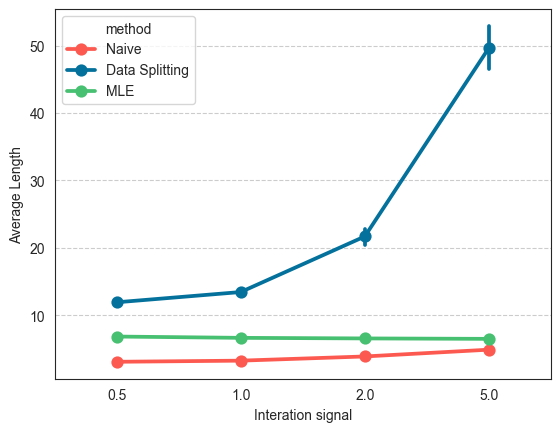

In [32]:
sns.pointplot(x=pd.DataFrame(oper_char_full)["inter signal"],
              y=pd.DataFrame(oper_char_full)["avg length"],
              hue=pd.DataFrame(oper_char_full)["method"], markers='o',
              palette=my_palette)
#plt.ylim(10,35)
plt.xlabel(r"Interation signal")
plt.ylabel("Average Length")

Text(0, 0.5, 'Test MSE')

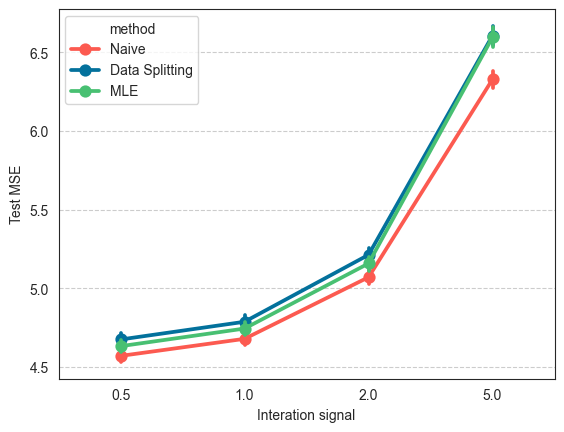

In [33]:
sns.pointplot(x=pd.DataFrame(MSE_dict_full)["inter signal"],
              y=pd.DataFrame(MSE_dict_full)["MSE"],
              hue=pd.DataFrame(MSE_dict_full)["method"], markers='o',
              palette=my_palette)
#plt.ylim(25,30)
plt.xlabel("Interation signal")
plt.ylabel("Test MSE")

# Applying BY Correction to the p-values

In [34]:
from collections import defaultdict
from scipy.stats import false_discovery_control


def add_BY_pval_by_method_and_index(data):
    # Check if BYpval is there
    if "BYpval" in data.keys():
        return
    # Assuming your dictionary is named 'data' and structured as described
    methods = data['method']
    indices = data['index']
    pvals = data['pval']

    # Initialize default dictionaries to collect p-values and positions for each (method, index) pair
    pvals_dict = defaultdict(list)
    pos_dict = defaultdict(list)

    # Iterate over the data and populate the dictionaries
    for i, (method, index, pval) in enumerate(zip(methods, indices, pvals)):
        key = (method, index)
        pvals_dict[key].append(pval)
        pos_dict[key].append(i)

    # Initialize BYpvals array with the same length as pvals
    BYpvals = [0] * len(pvals)  # or use numpy.zeros_like(pvals) if pvals is a numpy array

    # Apply BY correction and assign back to positions
    for key in pvals_dict:
        pvals_list = pvals_dict[key]
        positions = pos_dict[key]
        corrected_pvals = false_discovery_control(pvals_list, method='by')
        for pos, by_pval in zip(positions, corrected_pvals):
            BYpvals[pos] = by_pval

    # Add BYpvals to the original data dictionary
    data['BYpvals'] = BYpvals

    # Now, pvals_dict contains lists of p-values for each unique (method, index) pair

In [35]:
add_BY_pval_by_method_and_index(target_dict_full)

# Calculating Thresholded Power

In [36]:
def calculate_thresholded_power(pvalue, targets, level, threshold=0.05,
                                operator=ge):
    pvalue = np.array(pvalue)
    targets = np.array(targets)
    non_null = operator(np.abs(targets), threshold)
    rejection = pvalue < level
    if np.sum(non_null) == 0 or np.sum(rejection) == 0:
        return 0
    else:
        if operator == ge:
            true_rej = np.sum(non_null * rejection) / np.sum(non_null)
        else:
            true_rej = np.sum(non_null * rejection) / np.sum(rejection)

    return true_rej

def calculate_thresholded_power_df(targets_dict,
                                   threshold=0.1,
                                   level=0.1,
                                   operator=ge, 
                                   pval_key = "BYpvals"):
    grouped_targets = pd.DataFrame(targets_dict).groupby(['index',
                                                          'method', 'parameter'])
    power_df = {}
    power_df['parameter'] = []
    power_df['method'] = []
    power_df['thresholded power'] = []
    for name, group in grouped_targets:
        power_df['parameter'].append(name[2])
        power_df['method'].append(name[1])
        pvalues = group[pval_key]
        targets = group['target']
        power_df['thresholded power'].append(
            calculate_thresholded_power(pvalues, targets, level=level, 
                                        threshold=threshold, operator=operator))
    return power_df

In [37]:
def point_plot_power(oper_char_dfs, x_axis='p', hue='method', 
                     ylim_low=None, ylim_high=None, exclude_naive=True,
                     randomizer_scales=None, x_label=None):
    for i in range(len(oper_char_dfs)):
        oper_char_dfs[i] = oper_char_dfs[i].copy()
        if exclude_naive:
            oper_char_dfs[i] = oper_char_dfs[i][oper_char_dfs[i]['method'] != "Naive"]
    sns.set_style("white", {'axes.facecolor': 'white',
                            'axes.grid': True,
                            'axes.linewidth': 2.0,
                            'grid.linestyle': u'--',
                            'grid.linewidth': 4.0,
                            'xtick.major.size': 5.0,
                            })
    # sns.histplot(oper_char_df["sparsity size"])
    # plt.show()
    n_subplots = len(oper_char_dfs)
    # cols = int(np.ceil(n_subplots / 2))
    cols = n_subplots

    fig = plt.figure(figsize=(cols * 5, 6))

    my_palette = {"MLE": "#48c072",
                  "Naive": "#fc5a50",
                  "Data Splitting": "#03719c"}

    # Create each subplot
    for i in range(1, n_subplots + 1):
        # ax = fig.add_subplot(2, cols, i) #two rows
        ax = fig.add_subplot(1, cols, i)  # one row
        if hue is not None:
            sns.pointplot(x=oper_char_dfs[i-1][x_axis],
                          y=oper_char_dfs[i-1]['thresholded power'],
                          hue=oper_char_dfs[i-1][hue],
                          markers='o',
                          palette=my_palette,
                          ax=ax)
            ax.set_title("Randomizer Scale:" + str(randomizer_scales[i-1]))
        else:
            sns.pointplot(x=oper_char_dfs[i-1][x_axis],
                          y=oper_char_dfs[i-1]['thresholded power'],
                          markers='o',
                          palette=my_palette,
                          ax=ax)
        if ylim_low is not None and ylim_high is not None:
            ax.set_ylim([ylim_low, ylim_high])

        ax.legend().set_visible(False)

    handles, labels = ax.get_legend_handles_labels()
    # fig.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.2)

    fig.subplots_adjust(bottom=0.3)
    fig.legend(handles, labels, loc='lower center', ncol=n_subplots,
               prop={'size': 15})

    # cov_plot.legend_.remove()
    # len_plot.legend_.remove()

    # plt.suptitle("Changing n,p")
    plt.subplots_adjust(wspace=0.3, hspace=0.5)
    if x_label is not None:
        plt.xlabel(x_label)
    plt.show()

In [38]:
power_threshold = 1
power_df1 = calculate_thresholded_power_df(targets_dict=target_dict_full, 
                                           threshold=power_threshold, level=0.1,
                                           operator=ge, pval_key="BYpvals")

In [20]:
my_palette = {"MLE": "#48c072",
                  "Naive": "#fc5a50",
                  "Data Splitting": "#03719c"}

Text(0, 0.5, 'Thresholded Power (BY)')

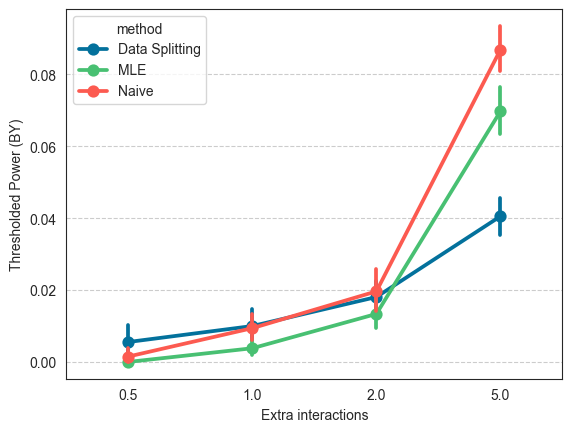

In [21]:
df = pd.DataFrame(power_df1)
#df = df[df["method"] != "Naive"]
sns.pointplot(x=df["parameter"],
              y=df["thresholded power"],
              hue=df["method"], markers='o',
              palette=my_palette)
plt.xlabel("Extra interactions")
plt.ylabel("Thresholded Power (BY)")

Text(0, 0.5, 'FDP (BY)')

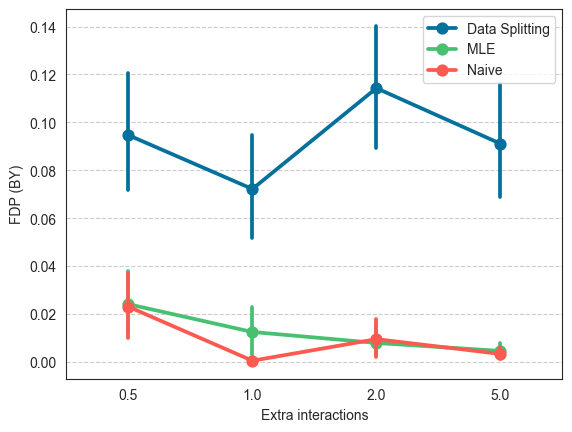

In [22]:
power_threshold = 1
FDP_df1 = calculate_thresholded_power_df(targets_dict=target_dict_full,
                                           threshold=power_threshold, level=0.1,
                                           operator=le, pval_key="BYpvals")
sns.pointplot(x=FDP_df1["parameter"],
              y=FDP_df1["thresholded power"],
              hue=FDP_df1["method"], markers='o',
              palette=my_palette)
plt.xlabel("Extra interactions")
plt.ylabel("FDP (BY)")

# Power and FDP without Correction

In [23]:
power_threshold = 1
power_df1_noBY = calculate_thresholded_power_df(targets_dict=target_dict_full, 
                                           threshold=power_threshold, level=0.1,
                                           operator=ge, pval_key="pval")

In [24]:
my_palette = {"MLE": "#48c072",
                  "Naive": "#fc5a50",
                  "Data Splitting": "#03719c"}

Text(0, 0.5, 'Thresholded Power (non-BY)')

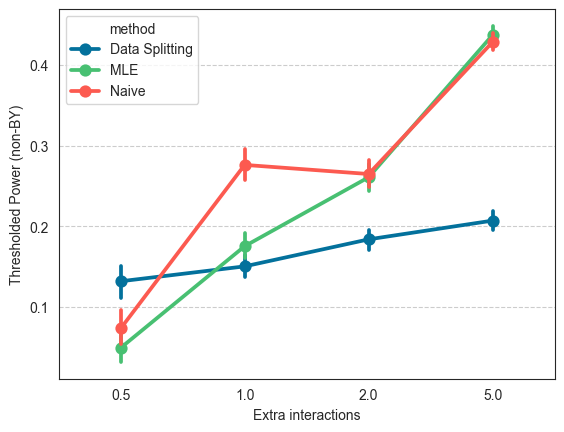

In [25]:
df = pd.DataFrame(power_df1_noBY)
#df = df[df["method"] != "Naive"]
sns.pointplot(x=df["parameter"],
              y=df["thresholded power"],
              hue=df["method"], markers='o',
              palette=my_palette)
plt.xlabel("Extra interactions")
plt.ylabel("Thresholded Power (non-BY)")

Text(0, 0.5, 'FDP (non-BY)')

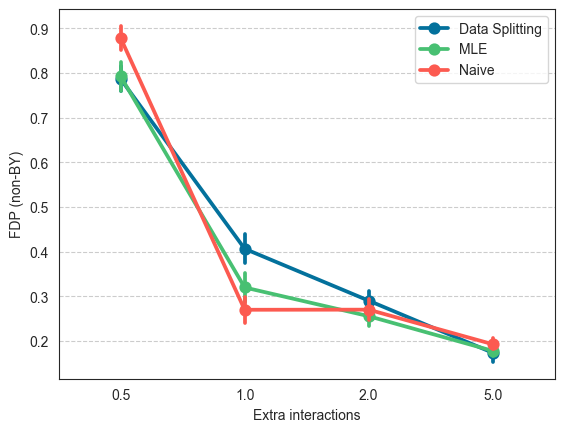

In [26]:
power_threshold = 1
FDP_df1_noBY = calculate_thresholded_power_df(targets_dict=target_dict_full,
                                           threshold=power_threshold, level=0.1,
                                           operator=le, pval_key="pval")
sns.pointplot(x=FDP_df1_noBY["parameter"],
              y=FDP_df1_noBY["thresholded power"],
              hue=FDP_df1_noBY["method"], markers='o',
              palette=my_palette)
plt.xlabel("Extra interactions")
plt.ylabel("FDP (non-BY)")

In [27]:
def power_plot(target_dict=None, thresholds=np.array(range(1,11))*0.1, level=0.1, pval_key="pval", show=True,
               parameter_name='parameter', operator=ge):
    yaxis_name_dict = {("pval", ge): "Power (non-BY)",
                       ("pval", le): "FDP (non-BY)",
                       ("BYpvals", ge): "Power (BY)",
                       ("BYpvals", le): "FDP (BY)",}
    # Collect the data for each threshold
    df_list = []
    for t in thresholds:
        df_t = calculate_thresholded_power_df(targets_dict=target_dict,
                                              threshold=t, level=level,
                                              operator=operator, pval_key=pval_key)     # compute power(t) -> DataFrame
        df_t = pd.DataFrame(df_t).copy()                      # so we can safely modify
        df_t['threshold'] = t                   # store which threshold was used
        df_list.append(df_t)

    # Concatenate all thresholded results
    df_all = pd.concat(df_list, ignore_index=True)
    
    df_plot = (
        df_all
        .groupby(['parameter', 'method', 'threshold'], as_index=False)
        .agg({'thresholded power': 'mean'})
    )

    # --- 4) Create separate plots for each p ---
    figures = {}
    unique_ps = df_plot['parameter'].unique()
    
    # Create a figure with 1 row and len(unique_ps) columns
    n_p = len(unique_ps)
    fig, axes = plt.subplots(
        1, 
        n_p, 
        figsize=(3 * n_p, 4),   # width scales with number of p's
        sharey=True             # share y-axis if desired
    )
    
    # If there's only one p, axes is not a list by default, so make it a list
    if n_p == 1:
        axes = [axes]
    
    for i, par_val in enumerate(unique_ps):
        ax = axes[i]
        
        # Filter to only rows where p == p_val
        df_p = df_plot[df_plot['parameter'] == par_val]
        
        # Seaborn lineplot
        sns.lineplot(
            data=df_p,
            x='threshold',
            y='thresholded power',
            hue='method',
            palette=my_palette,
            marker='o',
            ax=ax
        )
        
        ax.set_title(f'{parameter_name} = {par_val}')
        ax.set_xlabel('Threshold (t)')
        if i == 0:
            ax.set_ylabel(yaxis_name_dict[(pval_key, operator)])
        else:
            ax.set_ylabel('')  # to avoid repeating "Power(t)" on every subplot if you like

        ax.grid(True)
        
        # Optionally, move the legend to the first subplot only,
        # or keep them all. For a single legend, you could do:
        # if i == 0:
        #     ax.legend()
        # else:
        #     ax.get_legend().remove()

    # Optional: tighten layout
    plt.tight_layout()

    # 6) Show or return
    if show:
        plt.show()

# Power plot for non-BY p-values

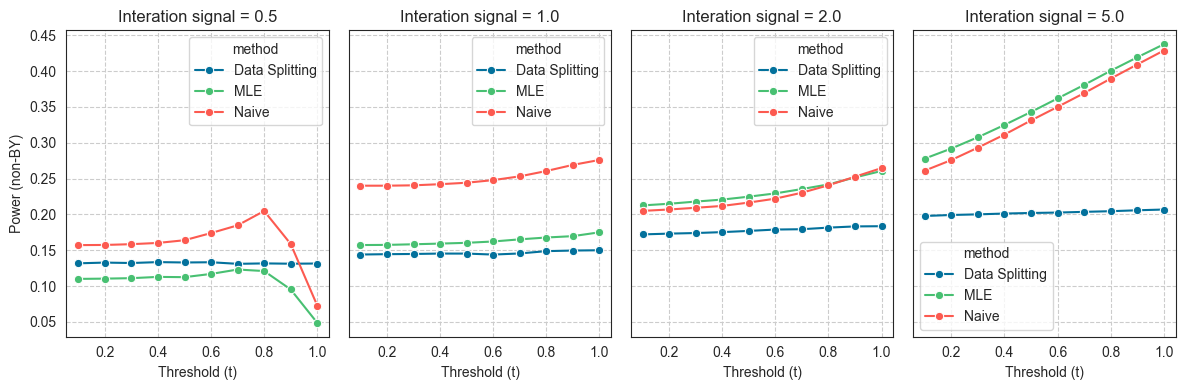

In [28]:
power_plot(target_dict=target_dict_full, pval_key="pval", parameter_name="Interation signal", operator=ge)

# FDP plot for non-BY p-values

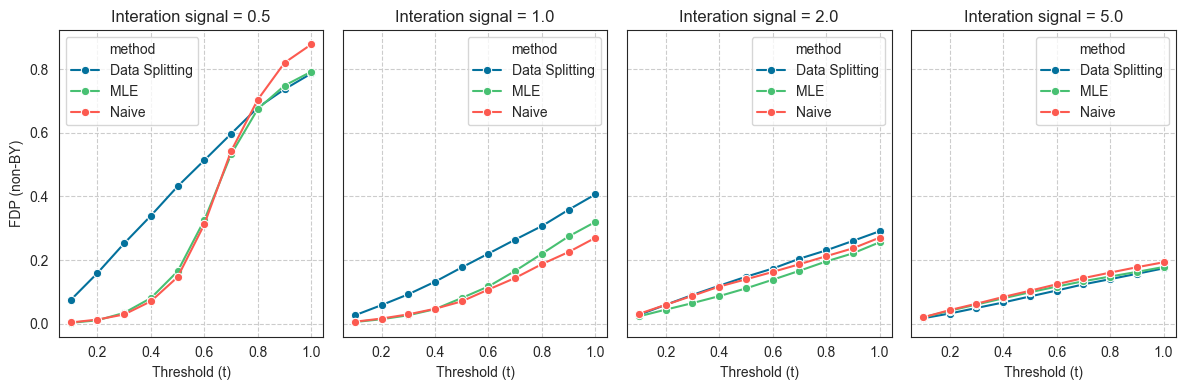

In [29]:
power_plot(target_dict=target_dict_full, pval_key="pval", parameter_name="Interation signal", operator=le)

# Power plot for BY p-values

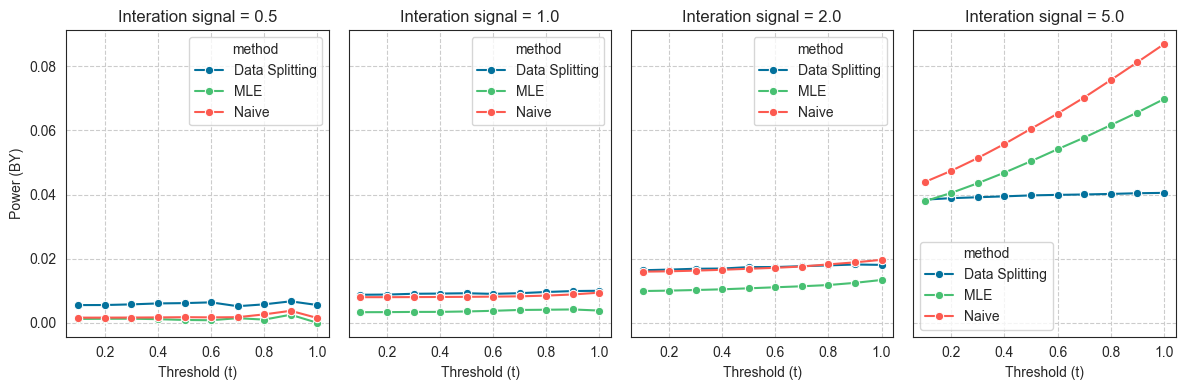

In [30]:
power_plot(target_dict=target_dict_full, pval_key="BYpvals", parameter_name="Interation signal", operator=ge)

# FDP for BY p-values

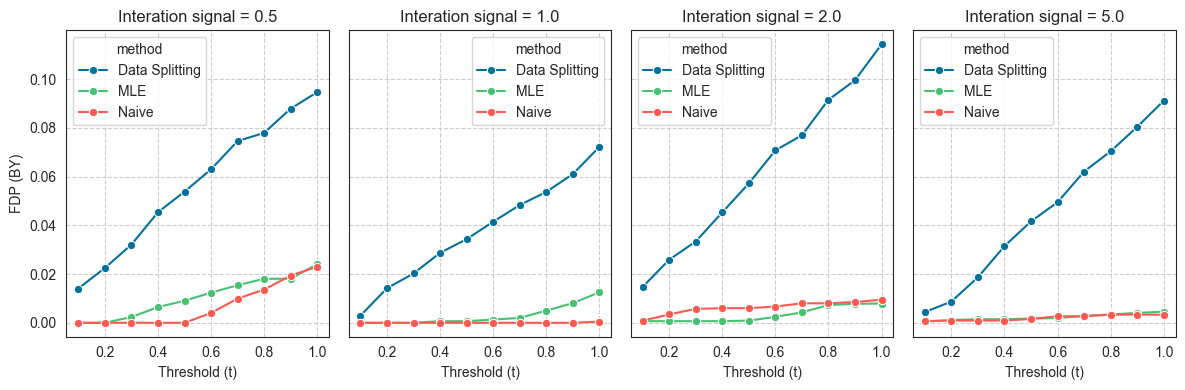

In [31]:
power_plot(target_dict=target_dict_full, pval_key="BYpvals", parameter_name="Interation signal", operator=le)

# F1 score plot for interaction p-values without BY

In [1]:
def calculate_F1_score(pvalue, targets, level, threshold=0.05):
    pvalue = np.array(pvalue)
    targets = np.array(targets)
    non_null = np.abs(targets) >= threshold
    rejection = pvalue < level
    if np.sum(non_null) == 0 or np.sum(rejection) == 0:
        return 0
    else:
        precision = np.sum(non_null * rejection) / np.sum(rejection)
        recall = np.sum(non_null * rejection) / np.sum(non_null)
        if precision * recall == 0:
            return 0
        F1 = 2 * precision * recall / (precision + recall)
    return F1

def calculate_F1_score_df(targets_dict,
                                   threshold=0.1,
                                   level=0.1,
                                   pval_key = "BYpvals"):
    grouped_targets = pd.DataFrame(targets_dict).groupby(['index',
                                                          'method', 'parameter'])
    power_df = {}
    power_df['parameter'] = []
    power_df['method'] = []
    power_df['F1 score'] = []
    for name, group in grouped_targets:
        power_df['parameter'].append(name[2])
        power_df['method'].append(name[1])
        pvalues = group[pval_key]
        targets = group['target']
        power_df['F1 score'].append(
            calculate_F1_score(pvalues, targets, level=level, threshold=threshold))
    return power_df

In [41]:
def F1_plot(target_dict=None, thresholds=np.array(range(1,11))*0.02, level=0.1, 
            pval_key="pval", show=True,
               parameter_name='parameter', operator=ge):
    yaxis_name_dict = {("pval", ge): "Power (non-BY)",
                       ("pval", le): "FDP (non-BY)",
                       ("BYpvals", ge): "Power (BY)",
                       ("BYpvals", le): "FDP (BY)",}
    # Collect the data for each threshold
    df_list = []
    for t in thresholds:
        df_t = calculate_F1_score_df(targets_dict=target_dict,
                                     threshold=t, level=level,
                                     pval_key=pval_key)     # compute power(t) -> DataFrame
        df_t = pd.DataFrame(df_t).copy()                      # so we can safely modify
        df_t['threshold'] = t                   # store which threshold was used
        df_list.append(df_t)

    # Concatenate all thresholded results
    df_all = pd.concat(df_list, ignore_index=True)
    
    df_plot = (
        df_all
        .groupby(['parameter', 'method', 'threshold'], as_index=False)
        .agg({'F1 score': 'mean'})
    )

    # --- 4) Create separate plots for each p ---
    figures = {}
    unique_ps = df_plot['parameter'].unique()
    
    # Create a figure with 1 row and len(unique_ps) columns
    n_p = len(unique_ps)
    fig, axes = plt.subplots(
        1, 
        n_p, 
        figsize=(3 * n_p, 4),   # width scales with number of p's
        sharey=True             # share y-axis if desired
    )
    
    # If there's only one p, axes is not a list by default, so make it a list
    if n_p == 1:
        axes = [axes]
    
    for i, par_val in enumerate(unique_ps):
        ax = axes[i]
        
        # Filter to only rows where p == p_val
        df_p = df_plot[df_plot['parameter'] == par_val]
        
        # Seaborn lineplot
        sns.lineplot(
            data=df_p,
            x='threshold',
            y='F1 score',
            hue='method',
            palette=my_palette,
            marker='o',
            ax=ax
        )
        
        ax.set_title(f'{parameter_name} = {par_val}')
        ax.set_xlabel('Threshold (t)')
        if i == 0:
            ax.set_ylabel(yaxis_name_dict[(pval_key, operator)])
        else:
            ax.set_ylabel('')  # to avoid repeating "Power(t)" on every subplot if you like

        ax.grid(True)
        
        # Optionally, move the legend to the first subplot only,
        # or keep them all. For a single legend, you could do:
        # if i == 0:
        #     ax.legend()
        # else:
        #     ax.get_legend().remove()

    # Optional: tighten layout
    plt.tight_layout()

    # 6) Show or return
    if show:
        plt.show()

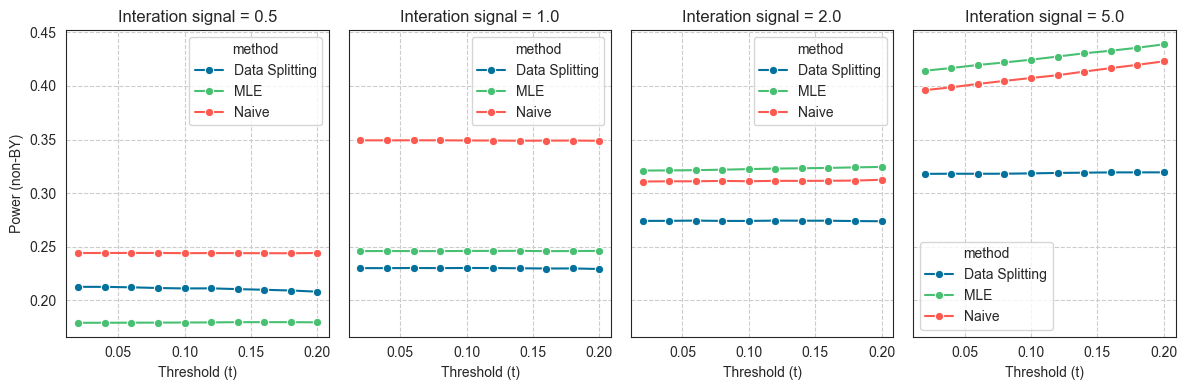

In [42]:
F1_plot(target_dict=target_dict_full, pval_key="pval", 
        parameter_name="Interation signal")

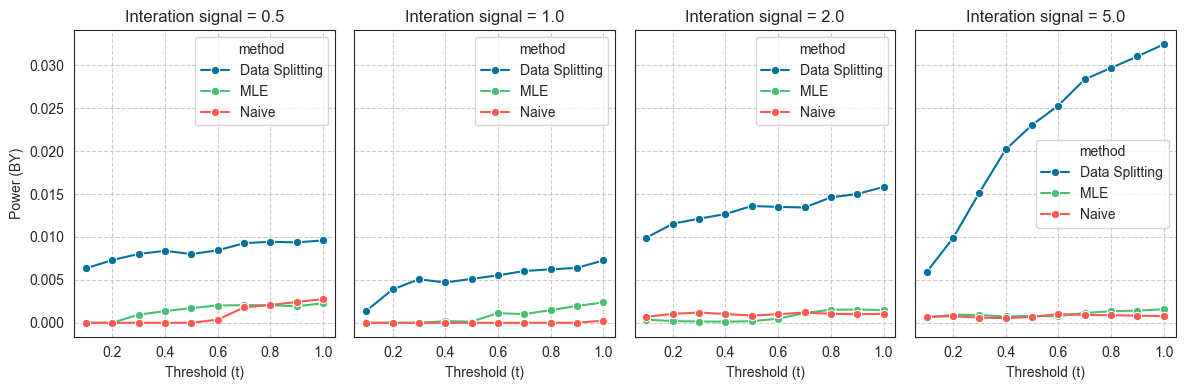

In [37]:
F1_plot(target_dict=target_dict_full, pval_key="BYpvals",
        parameter_name="Interation signal")

# Check Number of True & False Rejections

In [53]:
def calculate_metrics(pvalue, targets, level, type, threshold=0.05):
    # Type = "Total", "Rej", "NonNull", "TP", "TN", "FP", "FN" 
    pvalue = np.array(pvalue)
    targets = np.array(targets)
    non_null = np.abs(targets) >= threshold
    rejection = pvalue < level
    null = np.abs(targets) < threshold
    acceptance = pvalue >= level
    TP = np.sum(non_null * rejection)
    FP = np.sum(null * rejection)
    TN = np.sum(null * acceptance)
    FN = np.sum(non_null * acceptance)
    
    prec = TP/(TP + FP) if (np.sum(rejection) > 0) else 0
    recall = TP/(TP + FN) if (TP + FN > 0) else 0
    FDR = FP/(TP + FP) if (np.sum(rejection) > 0) else 0
    FPR = FP/(FP + TN) if (FP + TN > 0) else 0
    def E(s, p):
        return -np.sqrt((1-2*p)**2/4-2*s)-(1-2*p)/2
    if type == "Prec":
        return prec
    if type == "Recall":
        return recall
    if type == "FDR":
        return FDR
    if type == "FPR":
        return FPR
    if type == "F1":
        return 2 * prec * recall / (prec + recall) if (prec * recall != 0) else 0
        

def calculate_metric_df(targets_dict,
                          threshold=0.1,
                          level=0.1,
                          pval_key="pvals",
                        metric_list = ["Prec", "Recall", "FDR", "NonNull/Total"]):
    grouped_targets = pd.DataFrame(targets_dict).groupby(['index',
                                                          'method', 'parameter'])
    power_df = {}
    power_df['parameter'] = []
    power_df['method'] = []
    """metric_list = ["Total", "Card", "Rej", "NonNull", 
                   "TP", "TN", "FP", "FN", "ZeroRej","NonNull/Total"]"""
    for met in metric_list:
        power_df[met] = []
    
    for name, group in grouped_targets:
        power_df['parameter'].append(name[2])
        power_df['method'].append(name[1])
        pvalues = group[pval_key]
        targets = group['target']
        for met in metric_list:
            power_df[met].append(
                calculate_metrics(pvalues, targets, level=level,
                                  type=met, threshold=threshold)
            )
    return power_df

In [56]:
def metric_plot(target_dict=None, thresholds=np.array(range(1, 11)) * 0.02, level=0.1,
                pval_key="pval", 
                parameter_name='parameter', 
                metric_list=None):
    
    # Collect the data for each threshold
    df_list = []
    for t in thresholds:
        df_t = calculate_metric_df(targets_dict=target_dict,
                                     threshold=t, level=level,
                                     pval_key=pval_key,
                                   metric_list=metric_list)  # compute power(t) -> DataFrame
        df_t = pd.DataFrame(df_t).copy()  # so we can safely modify
        df_t['threshold'] = t  # store which threshold was used
        df_list.append(df_t)

    # Concatenate all thresholded results
    df_all = pd.concat(df_list, ignore_index=True)

    df_plot = (
        df_all
        .groupby(['parameter', 'method', 'threshold'], as_index=False)
        .agg({metric: "mean" for metric in metric_list})
    )

    # --- 4) Create separate plots for each p ---
    figures = {}
    unique_ps = df_plot['parameter'].unique()
    
    def plot_one_metric(metric):
        # Create a figure with 1 row and len(unique_ps) columns
        n_p = len(unique_ps)
        fig, axes = plt.subplots(
            1,
            n_p,
            figsize=(3 * n_p, 4),  # width scales with number of p's
            sharey=True  # share y-axis if desired
        )
    
        # If there's only one p, axes is not a list by default, so make it a list
        if n_p == 1:
            axes = [axes]
    
        for i, par_val in enumerate(unique_ps):
            ax = axes[i]
    
            # Filter to only rows where p == p_val
            df_p = df_plot[df_plot['parameter'] == par_val]
    
            # Seaborn lineplot
            sns.lineplot(
                data=df_p,
                x='threshold',
                y=metric,
                hue='method',
                palette=my_palette,
                marker='o',
                ax=ax
            )
    
            ax.set_title(f'{parameter_name} = {par_val}')
            ax.set_xlabel('Threshold (t)')
            if i == 0:
                ax.set_ylabel(metric)
            else:
                ax.set_ylabel('')  # to avoid repeating "Power(t)" on every subplot if you like
    
            ax.grid(True)
    
            # Optionally, move the legend to the first subplot only,
            # or keep them all. For a single legend, you could do:
            # if i == 0:
            #     ax.legend()
            # else:
            #     ax.get_legend().remove()
    
        # Optional: tighten layout
        plt.tight_layout()
        
        plt.show()
        
    for metric in metric_list:
        plot_one_metric(metric)

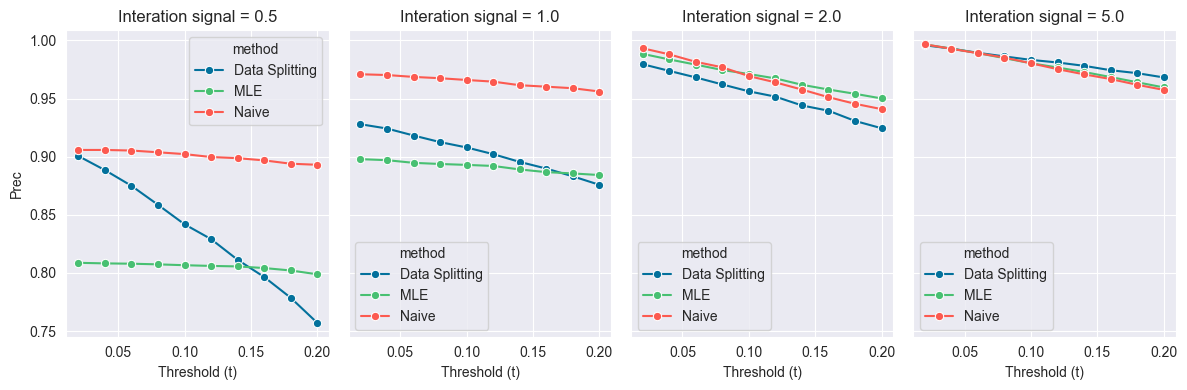

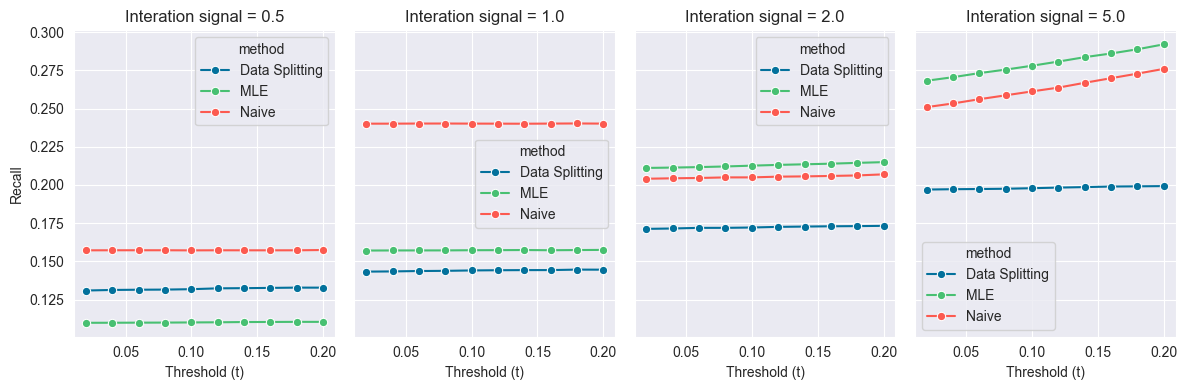

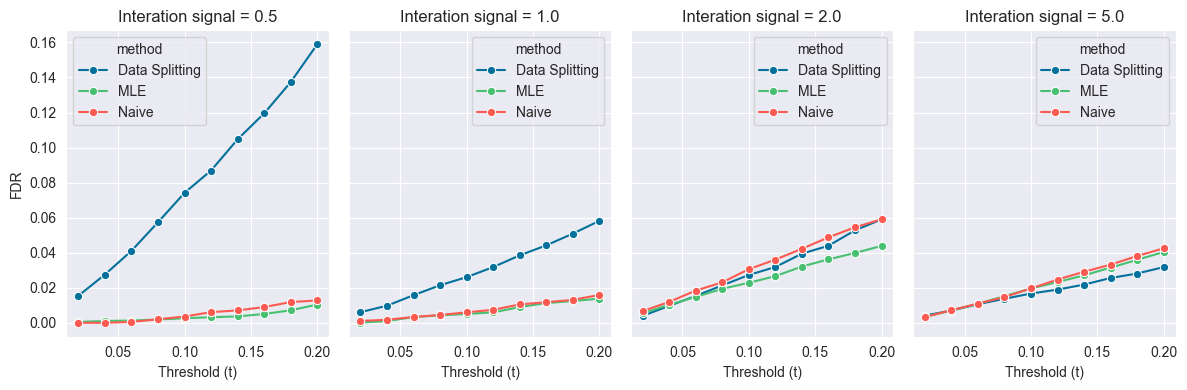

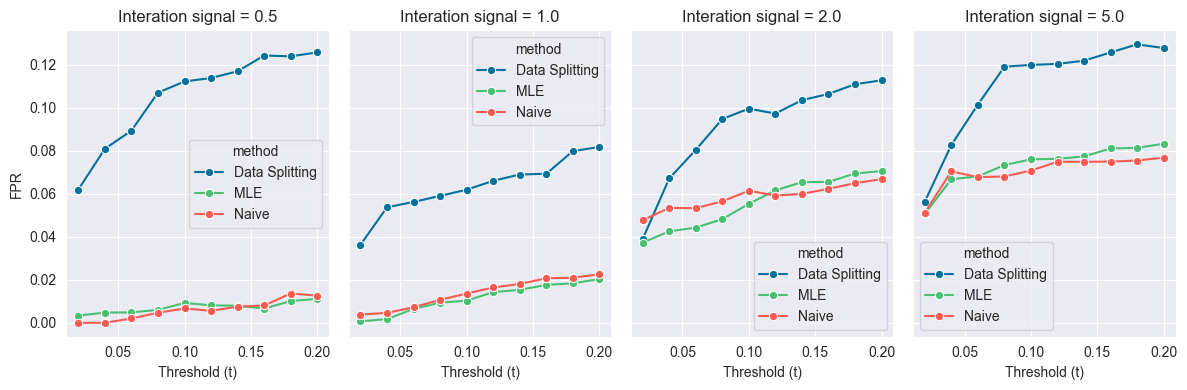

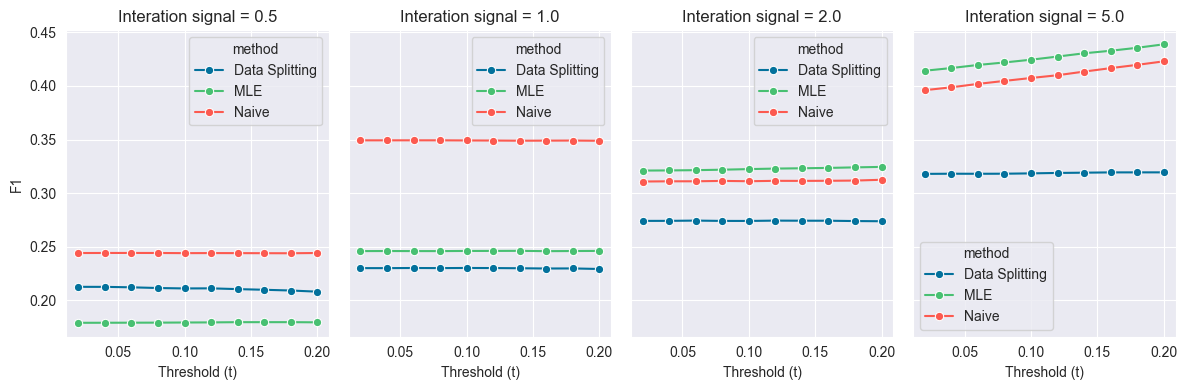

In [57]:
metric_plot(target_dict=target_dict_full, pval_key="pval",
            parameter_name="Interation signal", 
            metric_list=["Prec", "Recall", "FDR", "FPR", "F1"])

In [40]:
pd.DataFrame(target_dict_full).groupby(["method", "parameter"])['index'].nunique()

method          parameter
Data Splitting  0.5          500
                1.0          500
                2.0          486
                5.0          353
MLE             0.5          498
                1.0          500
                2.0          500
                5.0          500
Naive           0.5          499
                1.0          500
                2.0          500
                5.0          500
Name: index, dtype: int64

In [58]:
unique_idx = (
    pd.DataFrame(target_dict_full).groupby(["method", "parameter"])['index'].unique())
all_idx = set(range(500))
for key in unique_idx.index:
    missing_idx = all_idx.difference(set(unique_idx[key]))
    print(key, len(missing_idx))


('Data Splitting', 0.5) 0
('Data Splitting', 1.0) 0
('Data Splitting', 2.0) 14
('Data Splitting', 5.0) 147
('MLE', 0.5) 2
('MLE', 1.0) 0
('MLE', 2.0) 0
('MLE', 5.0) 0
('Naive', 0.5) 1
('Naive', 1.0) 0
('Naive', 2.0) 0
('Naive', 5.0) 0


In [60]:
pd.DataFrame(target_dict_full).groupby(["method", "parameter"])['index'].nunique()

method          parameter
Data Splitting  0.5          500
                1.0          500
                2.0          486
                5.0          353
MLE             0.5          498
                1.0          500
                2.0          500
                5.0          500
Naive           0.5          499
                1.0          500
                2.0          500
                5.0          500
Name: index, dtype: int64

In [61]:
ds_rank_def_count_full

{0.5: 0, 1.0: 0, 2.0: 161, 5.0: 0}

In [69]:
pd.DataFrame(oper_char_full).groupby(["method", "inter signal"]).size()

method          inter signal
Data Splitting  0.5             500
                1.0             500
                2.0             486
                5.0             353
MLE             0.5             498
                1.0             500
                2.0             500
                5.0             500
Naive           0.5             499
                1.0             500
                2.0             500
                5.0             500
dtype: int64

In [65]:
pd.DataFrame(oper_char_full)

,coverage rate,avg length,method,prop,rho,inter signal,target,power
0,0.972973,3.024081,Naive,0.9,0.5,0.5,0.394842,0.054054
1,0.888889,12.880666,Data Splitting,0.9,0.5,0.5,-0.359110,0.129630
2,0.962963,7.866514,MLE,0.9,0.5,0.5,0.528947,0.074074
3,0.972973,2.768410,Naive,0.9,0.5,0.5,0.939261,0.054054
4,0.962963,13.812997,Data Splitting,0.9,0.5,0.5,0.079462,0.111111
...,...,...,...,...,...,...,...,...
5831,0.965517,5.599495,Naive,0.9,0.5,5.0,5.062010,0.179310
5832,0.967532,7.526903,MLE,0.9,0.5,5.0,5.852639,0.201299
5833,0.969697,4.460111,Naive,0.9,0.5,5.0,9.166563,0.232323
5834,0.887097,26.437117,Data Splitting,0.9,0.5,5.0,13.469455,0.129032


In [70]:
1000 - 486 - 353

161